# Телеметрия за все годы проведения эксперимента СФЕРА на Байкале для статьи по телеметрии

In [1]:
!date
!pwd
#Ср дек  9 14:32:27 MSK 2020
#/home/alena/SCIENCE/SPHERE/Analysis/Telemetry

Ср янв 27 20:42:55 MSK 2021
/home/alena/SCIENCE/SPHERE/Analysis/Telemetry


In [13]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates
import datetime as dt
from math import pi
#чтобы датасеты с множеством колонок отображались полностью
pd.set_option('display.max_rows', 100, 'display.max_columns', 200)

In [18]:
plt.rcParams['figure.figsize'] =(8,4)
plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.markeredgewidth'] = 1
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 12

## Чтение данных

In [5]:
dirname = '~/SCIENCE/SPHERE/ExpData/Data.telemetry/'
!ls $dirname

2012_calibr_testrun	      datum_2012_sec.csv
2012_events.csv		      datum_2013_min.csv
2012_events.csv.bad	      datum_2013_sec.csv
2013_events.csv		      datum_2013_sec_H_correction.csv
current_hv_code_everymin.dat  high_code.dat
currents_corrected.txt	      high_kod.dat
datum_2009_sec.csv	      telemetry_min.csv
datum_2010_min.csv	      telemetry_min_initial.csv
datum_2010_sec.csv	      V_ham_2012.dat
datum_2011_min.csv	      V_ham_2012_initial.dat
datum_2011_sec.csv	      V_ham_2013.dat
datum_2012_min.csv


In [6]:
dirname = '~/SCIENCE/SPHERE/ExpData/Data.telemetry/'
name = 'telemetry_min.csv'
datum = pd.read_csv(dirname + name)
print(datum.shape)
datum.columns

(7169, 38)


Index(['Unnamed: 0', 'mm', 'year', 'month', 'day', 'time', 'N', 'E', 'H',
       'H-455', 'Gqi', 'Gsn', 'Ghdp', 'Ggs', 'compass', 'P0_code', 'T0_code',
       'P_hpa0', 'T0,C', 'P1_code', 'T1_code', 'P_hpa1', 'T1,C', 'U15,V',
       'U5,V', 'Uac,V', 'I,A', 'Tpow,C', 'Tmos,C', 'Bot,C', 'Top,C', 'Clin1',
       'Clin2', 'ClinTh', 'run', 'dN', 'dE', 'utime'],
      dtype='object')

In [7]:
show = [[2011, 1], [2011,2], [2012, 4], [2012, 5], [2013, 2], [2013, 5]]

def plot_for_paper_final(show, name, yaxislabel, file=None):

    flights = len(show)
    # рисование
    fmt = dates.DateFormatter('%H:%M')
    plcol = ['mP-','bx--', 'gs:', 'rd-.', 'co-', 'k*--']
    fig, ax = plt.subplots()

    for i in range(flights):
        data = datum[ (datum.year == show[i][0]) & (datum.run == show[i][1]) ]
        data = data[['utime', name]].dropna()
        x = [dt.datetime.strptime(i, '%H:%M:%S') for i in data.utime]
        y = data[name]
        #print(year, i, len(y))   

        #label = 'flight ' + str(i)
        label = str(show[i][0]) + '-' + str(show[i][1])
        if name in ['Clin1']:
            ax.plot(x, abs(y), plcol[i-1], alpha=0.9, label = label)
        else:
            ax.plot(x, y, plcol[i-1], alpha=0.9, label = label)

    if name in ['H-455','ClinTh']:
        plt.ylim(0)
     
    ax.xaxis.set_major_formatter(fmt)
    plt.xlabel('Flight time, UTC')
    plt.ylabel(yaxislabel)
    plt.legend(borderaxespad=0.1)
    plt.grid()
    
    # save file
    if file:
        plt.savefig(file, bbox_inches='tight')    

### Высота

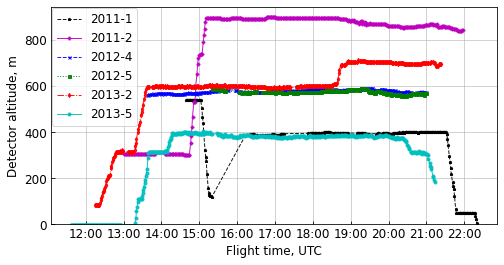

In [8]:
plot_for_paper_final(show, 'H-455', 'Detector altitude, m', 'Telemetry_height.pdf')

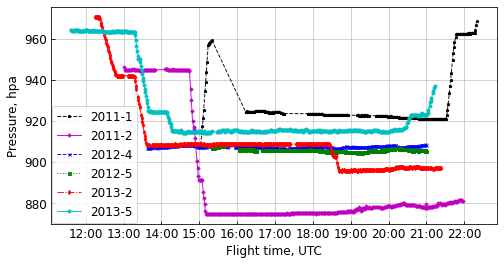

In [9]:
""" давление внутри аппаратуры """
plot_for_paper_final(show, 'P_hpa0', 'Pressure, hpa', 'Telemetry_pressure.pdf')

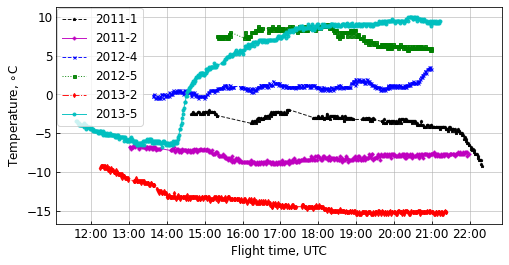

In [10]:
""" температура мозаики """
plot_for_paper_final(show, 'Tmos,C',  'Temperature, $\circ$C', 'Telemetry_tmos.pdf')

### Наклон 

In [10]:
pi = 3.14151926535
def grad_to_rad(x):
    return x * pi / 180

def rad_to_grad(x):
    return x * 180 / pi

#print(rad_to_grad(pi))
#print(grad_to_rad(180))

In [11]:
from math import sqrt
### Отклонение от первоначального подвеса
### acos( (tan(a0) * tan(a) + tan(b0) * tan(b) + 1)/sqrt((tan(a0)^2+tan(b0)^2+1)*(tan(a)^2+tan(b)^2+1)) )
def deflection(a0, b0, a, b):
    a0 = grad_to_rad(a0)
    b0 = grad_to_rad(b0)
    a = grad_to_rad(a)
    b = grad_to_rad(b)
    return rad_to_grad(
          np.arccos( (np.tan(a0) * np.tan(a) + np.tan(b0) * np.tan(b) + 1) / 
                sqrt((np.tan(a0) ** 2 + np.tan(b0) ** 2 + 1) * 
                     (np.tan(a)  ** 2 + np.tan(b)  ** 2 + 1)) 
                   )
    )


def calc_deflection(a, b, year, run):
    if year == 2013:
        #a0 = [-2.3, -1.2, -2.5, -2.6, -2.9]  # from debug
        #b0 = [ 1.4, -1.1,  1.5, -0.6,  1.0]  # from debug
        #a0 = [-2.5, -0.6, -2.4, -2.6, -0.4]   # from min distance from start point
        #b0 = [ 1.4,  0.3,  1.5, -0.6,  1.2]   # from min distance from start point
        a0 = [-2.5, -0.8, -2.6, -2.6, -2.9]   # from min distance from start point
        b0 = [ 1.4,  0.3,  1.3, -0.6,  1.1]   # from min distance from start point
    elif year == 2012:
        #a0 = [ 0.8, -4.0, -4.2, -2.2, -3.1]
        #b0 = [ 2.7,  2.0, 1.3,  0.4,  0.1]
        a0 = [ 0.1, -3.0, -1.0, -2.5, -2.5]
        b0 = [ 2.5,  1.8, 2.0,  0.4,  0.1]
    elif year == 2011:
        #a0 = [-2.0, -0.2, -1.2, -2.5]
        #b0 = [ 0.2,  2.0,  1.7, -0.1]
        a0 = [-2.5, -0.2,  -0.0, -2.0]
        b0 = [ 0.4,  2.1,  2.1, -0.1]
    else:
        #print("Unknown year!")
        return 0
    
    return deflection(a0[run - 1], b0[run - 1], a, b)

In [14]:
datum['dev'] = datum.apply(lambda row: calc_deflection(row['Clin1'], row['Clin2'], row['year'], row['run']), axis = 1)

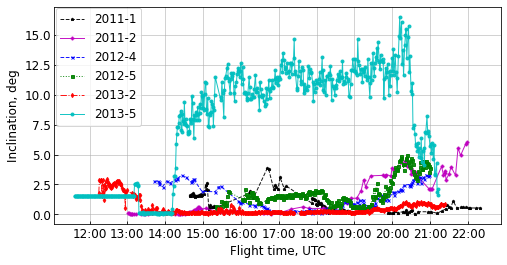

In [20]:
plot_for_paper_final(show, 'dev', 'Inclination, deg', 'Telemetry_inclination11.pdf')

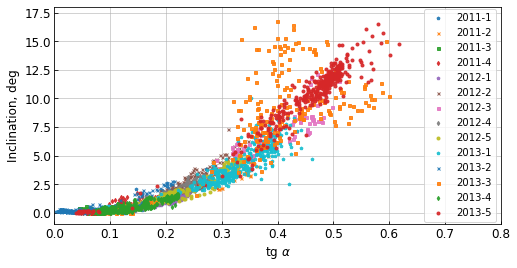

In [19]:
""" наклон при разных сносах установки """
plcol = ['mp-','bx--', 'gs:', 'rd-.', 'co-']
params = ['H-455', 'dev', 'dE', 'dN']
fig = plt.figure(figsize=(8,4))

plcol = ['p-','x--', 's:', 'd-.', 'o-']
for year in range(2011, 2014):
    if year == 2013:
        color = 'b'
    elif year == 2012:
        color = 'g'
    for i in range(1,6):
        if year == 2011 and i == 5:
            continue
        data = datum[(datum.run == i) & (datum["H-455"] > 290) & (datum.year == year)][params].dropna()
        x = data.dE
        y = data.dN
        r = (x * x + y * y) ** 0.5    
        x = r/data['H-455']
        y = data.dev
        ymin = min(y)
        #y = y - ymin
        label = str(year) + '-' + str(i)
        plt.plot(x, y, plcol[i-1][0:1], alpha=0.9, label = label)

plt.legend(loc=5, fontsize=10)

plt.xlim(0, 0.8)
plt.ylim(-1, 18)
plt.xlabel('tg $\\alpha$')
plt.ylabel("Inclination, deg")
plt.grid()

plt.savefig('tg-inclination.pdf', bbox_inches='tight')
plt.savefig('tg-inclination.png', bbox_inches='tight')

### Распределение по высотам

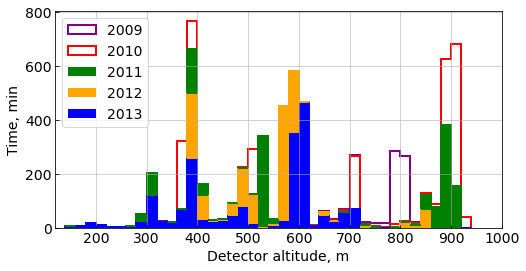

In [21]:
""" Время на разных высотах за все время"""
fig = plt.figure(figsize=(8,4))
#fig = plt.figure(figsize=(16,6))
plt.rcParams['font.size'] = 14

hmin = 140
bins = 40
hmax = hmin + 20 * bins
#colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
#plcol = ['m','b', 'g', 'r', 'c', 'k']
plcol = ['b','orange', 'g', 'r', 'purple', 'k']

x1 = []
label = []
for year in range(2013, 2008, -1):
    x1.append(datum["H-455"][datum.year == year])
    if year <= 2010:
        label.append(str(year))
    else:
        label.append("")
plt.hist(x1, range=[hmin, hmax], bins=bins,
             histtype='step', linewidth=2, color=plcol[:5],
             stacked=True, 
             label=label)

x = []
label = []
for year in range(2013, 2010, -1):
    x.append(datum["H-455"][datum.year == year])
    label.append(str(year))
plt.hist(x, range=[hmin, hmax], bins=bins,
             histtype='stepfilled', color=plcol[:3],
             stacked=True, 
             label=label)

plt.xlim(120, 1000)
#plt.ylim(0, 1250)
plt.xlabel('Detector altitude, m')
plt.ylabel("Time, min")
plt.legend(loc=2)
plt.grid()
plt.savefig("time_on_altitude.pdf", bbox_inches='tight')    

# THE END 